# Import

In [80]:
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table

# Data

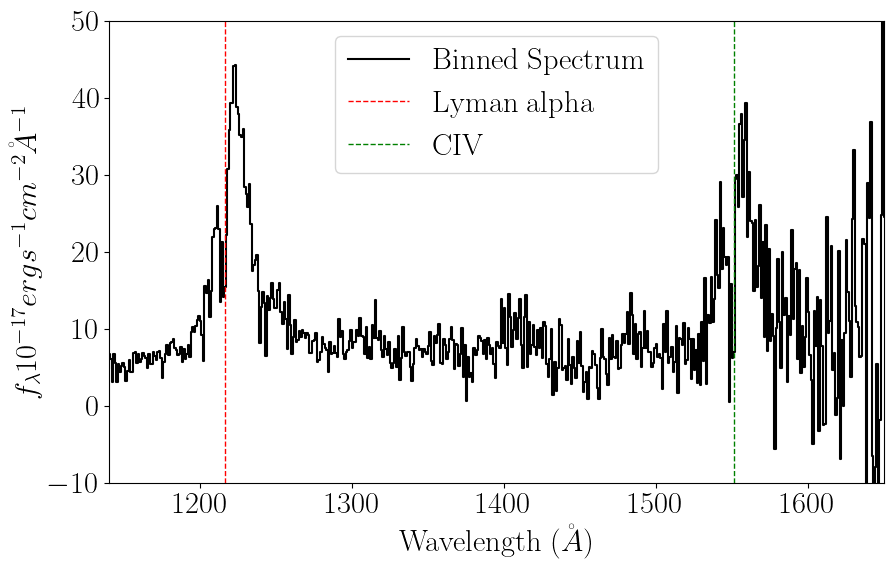

In [81]:
file_path = 'uvspec_jcr/ascii/bbh019_20220412_COSl.dat'
z = 0.2144

# Load the data and handle headers manually
df = pd.read_csv(file_path, delim_whitespace=True, skiprows=7, header=None)

# Manually set column names assuming the first 3 columns are the data we need
df = df.iloc[:, :3]
df.columns = ['Wavelength', 'F_lambda', 'e_F_lambda']

# Convert columns to appropriate types
df = df.apply(pd.to_numeric)

# Sort by Wavelength
df.sort_values('Wavelength', inplace=True)

# Binning parameters
bin_width = 1
bins = np.arange(min(df["Wavelength"]), max(df["Wavelength"]) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(df["Wavelength"], bins)

binned_wl = []
binned_flux = []
binned_flux_err = []

# Bin the data
for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(df["Wavelength"][in_bin]))
        binned_flux.append(np.mean(df["F_lambda"][in_bin]))
        binned_flux_err.append(np.mean(df["e_F_lambda"][in_bin]))

binned_wl = np.array(binned_wl) #/ (1+z)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(binned_wl, binned_flux, label='Binned Spectrum', color="black", drawstyle='steps-mid')
#plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
plt.axvline(x=1216, color='r', linestyle='--', linewidth=1, label="Lyman alpha")
plt.axvline(x=1550.772, color='g', linestyle='--', linewidth=1, label="CIV")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
plt.xlim(1140, 1650)
plt.ylim(-10, 50)
plt.legend()
plt.show()


# Functions

In [82]:
def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [83]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [84]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(fwhm),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [85]:
# Need to change for UV

def uv_agn_spectrum(wave_to_fit,pl_s,pl_e,\
                    ly1_f,ly1_cent,ly1_fwhm,\
                    ly2_f,ly2_cent,ly2_fwhm,\
                    ly3_f,ly3_cent,ly3_fwhm,\
                    o1_f,o1_cent,o1_fwhm,\
                    #o2_f,o2_cent,o2_fwhm,\
                    si1_f,si1_cent,si1_fwhm,\
                    civ1_f,civ1_cent,civ1_fwhm,\
                    civ2_f,civ2_cent,civ2_fwhm,\
                         return_components=False,return_hyperfine_components=False):
    """
    Calculates a full optical AGN spectral model.
    """
    
    #x = wave_to_fit.to_value()
    x = np.array(wave_to_fit)
    y = np.zeros_like(x)
    
    # powerlaw
    pl = powerlaw(x,pl_s,pl_e)
    
    # uv Ly alph template
    ly1 = gaussian(x,ly1_f,ly1_cent,ly1_fwhm,normalized=False)
    ly2 = gaussian(x,ly2_f,ly2_cent,ly2_fwhm,normalized=False)
    ly3 = gaussian(x,ly3_f,ly3_cent,ly3_fwhm,normalized=False)
    
    # uv Ly alph template
    o1 = gaussian(x,o1_f,o1_cent,o1_fwhm,normalized=False)
    #o2 = gaussian(x,o2_f,o2_cent,o2_fwhm,normalized=False)
    
    # uv Si I template
    si1 = gaussian(x,si1_f,si1_cent,si1_fwhm,normalized=False)
    
    # uv C IV template
    civ1 = gaussian(x,civ1_f,civ1_cent,civ1_fwhm,normalized=False)
    civ2 = gaussian(x,civ2_f,civ2_cent,civ2_fwhm,normalized=False)
    
   
    y = pl + ly1 +ly2 + ly3 + si1 + o1 + civ1 + civ2 
    
    
    if return_components:
        y = {'model':y,\
             'pl':pl,\
             'ly1':ly1,\
             'ly2':ly2,\
             'ly3':ly3,\
             'o1':o1,\
             #'o2':o2,\
             'si1':si1,\
             'civ1': civ1,\
             'civ2':civ2}  
    
    return y

In [86]:
def pl_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(plaw, 2,
            parnames=['scale','power'], 
            parlimited=[(False,False),(False,False)], 
            parlimits=[(0,0),(0,0)], 
            shortvarnames=('S','P')
            )
    myclass.__name__ = "pl"
    
    return myclass

In [87]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [88]:
# Need to change

def uv_agn_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(uv_agn_spectrum, 23,
            parnames=['pl_s','pl_e',\
                      'ly1_f', 'ly1_cent', 'ly1_fwhm',\
                      'ly2_f', 'ly2_cent', 'ly2_fwhm',\
                      'ly3_f', 'ly3_cent', 'ly3_fwhm',\
                      'o1_f', 'o1_cent', 'o1_fwhm',\
                      #'o2_f', 'o2_cent', 'o2_fwhm',\
                      'si1_f', 'si1_cent', 'si1_fwhm',\
                      'civ1_f', 'civ1_cent', 'civ1_fwhm',\
                      'civ2_f', 'civ2_cent', 'civ2_fwhm'], 
            parlimited=[(False,False),(False,False),\
                        (False,False), (False,False), (False,False),\
                        (False,False), (False,False), (False,False),\
                        #(False,False), (False,False), (False,False),\
                        (False,False), (False,False), (False,False),\
                        (False,False), (False,False), (False,False),\
                        (False,False), (False,False), (False,False),\
                        (False,False), (False,False), (False,False),\
                        (False,False), (False,False), (False,False)], 
            parlimits=[(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       #(0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0)]
            )
    myclass.__name__ = "uvagn"
    
    return myclass

In [89]:
def plot_uv_agn_fit(wave,flux,model,wavemin,wavemax,ymin,ymax,xlabel,ylabel,plotfile,HARDCOPY=False,SHOW=True):
    ly1 = model['ly1']
    ly2 = model['ly2']
    ly3 = model['ly3']
    o1 = model['o1']
    #o2 = model['o2']
    si1 = model['si1']
    civ1 = model['civ1']
    civ2 = model['civ2']
    
    
    
    fig = plt.figure(figsize=(18, 6))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=indian_red,lw=2)
    ax.plot(wave,model['pl'],color=royal_blue)
    ax.plot(wave,ly1,color=green)
    ax.plot(wave,ly2,color=green)
    ax.plot(wave,ly3,color=green)
    ax.plot(wave,civ1,color=dark_orange)
    ax.plot(wave,civ2,color=dark_orange)
    ax.plot(wave,o1,color=goldenrod)
    #ax.plot(wave,o2,color=turquoise)
    ax.plot(wave,si1,color=turquoise)
    ax.set_xlim(wavemin,wavemax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel,size=24)
    ax.set_ylabel(ylabel,size=24)
    plt.tight_layout()
    if HARDCOPY: fig.savefig(plotfile+'_fullfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)
    


In [90]:
# SETUP 
##############################################################
##############################################################
fontfamily = 'Times New Roman'
matplotlib.rcParams['font.family'] = fontfamily
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
plt.rc('xtick.major',pad=2)
plt.rc('ytick.major',pad=2)
plt.rc('xtick.minor',pad=2)
plt.rc('ytick.minor',pad=2)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('font',size=24,weight='bold')
plt.rcParams['axes.labelweight'] = 'bold'

blood_orange = [204/255,17/255,0/255]
indian_red = [176/255,23/255,31/255]
indian_red = [200/255,23/255,31/255]
green = [0/255,205/255,0/255]
dark_orange = [255/255,127/255,0/255]
goldenrod = [255/255,193/255,37/255]
midnight_blue = [25/255,25/255,112/255]
transparent_blue = [138/255,181/255,220/255]
gray = [130/255,130/255,130/255]
dark_gray = [50/255,50/255,50/255]
salmon = [250/255,128/255,114/255]
royal_blue = [0/255,0/255,200/255]
turquoise  = [0/255,204/255,204/255]
cyan  = [0/255,255/255,255/255]
pink = [255/255,0/255,127/255]
med_pink = [191/255, 0/255, 96/255]
dark_pink = [128/255, 0/255, 64/255]

# Fitting

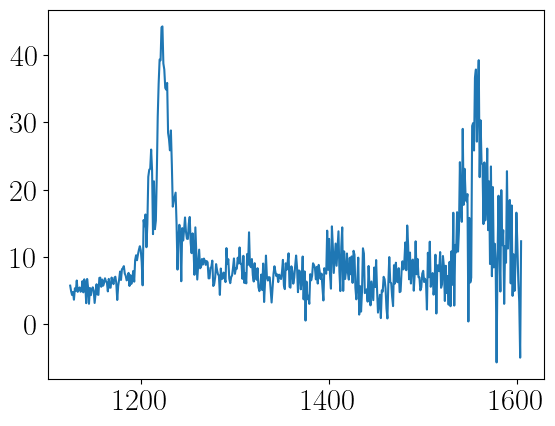

In [105]:
a = np.where((binned_wl < 1605) & (binned_wl > 1125))[0]

flux = binned_flux[a]
lam = binned_wl[a]
err = binned_flux_err[a]

plt.plot(lam, flux)
plt.show()

In [106]:
# set up the relevant emission lines

ly = 1216 + 7
oi = 1302.168
si = 1398.33
c4 = 1546.15

#line_off = o1_e/ly_e

c = 2.99e5 # km/s

In [383]:
# Need to change
guesses = [5, 0,\
           35, ly+7, 2500,\
           20, ly-7, 1500,\
           10, ly+10, 12000,\
           #15, oi, 8000,\
           10, oi, 3000,\
           20, si, 5000,\
           40, c4, 5000,\
           40, c4-5, 2000]

step = [0.5, 0.05,\
        0.5, 0.1, 5,\
        #0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5]
           
tied = ['','',\
        '','','',\
        '','','',\
        '','','',\
        '','','',\
        #'','','',\
        '','','',\
        '','','',\
        '','','']

fixed = [0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         #0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0]

In [384]:
# this actually does the fit after resetting the spectrum
spec = pyspeckit.Spectrum(data=flux, xarr=lam,error=err)
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
spec.Registry.add_fitter('uvagn',uv_agn_fitter(),23)
spec.specfit.selectregion(xmin=1300,xmax=1650)
spec.specfit(fittype='uvagn',vheight=False,guesses=guesses,tied=tied,fixed=fixed,parsteps=step,maxiter=5000,baseline=False,subtract_baseline=False,quiet=False)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 175,480 [pyspeckit.spectrum.interactive]
Iter       1    CHI-SQUARE =  84.91597541  DOF =  282
   PL_S0 = 5  
   PL_E0 = 0  
   LY1_F0 = 35  
   LY1_CENT0 = 1223  
   LY1_FWHM0 = 2500  
   LY2_F0 = 20  
   LY2_CENT0 = 1209  
   LY2_FWHM0 = 1500  
   LY3_F0 = 10  
   LY3_CENT0 = 1226  
   LY3_FWHM0 = 12000  
   O1_F0 = 10  
   O1_CENT0 = 1302.168  
   O1_FWHM0 = 3000  
   SI1_F0 = 20  
   SI1_CENT0 = 1398.33  
   SI1_FWHM0 = 5000  
   CIV1_F0 = 40  
   CIV1_CENT0 = 1546.15  
   CIV1_FWHM0 = 5000  
   CIV2_F0 = 40  
   CIV2_CENT0 = 1541.15  
   CIV2_FWHM0 = 2000  
Iter       2    CHI-SQUARE =  18.613413  DOF =  282
   PL_S0 = 5.407450377  
   PL_E0 = -0.2086238553  
   LY1_F0 = 35  
   LY1_CENT0 = 1223  
   LY1_FWHM0 = 2500  
   LY2_F0 = 20  
   LY2_CENT0 = 1209  
   LY2_FWHM0 = 1500  
   LY3_F0 = -1121.56507  
   LY3_CENT0 = 648.5464176  
   LY3_FWHM0 = -80420.8558  
   O1_F0 = 8.228293962  
   O1_CENT0 = 1301.91742  
   O1_FWHM0

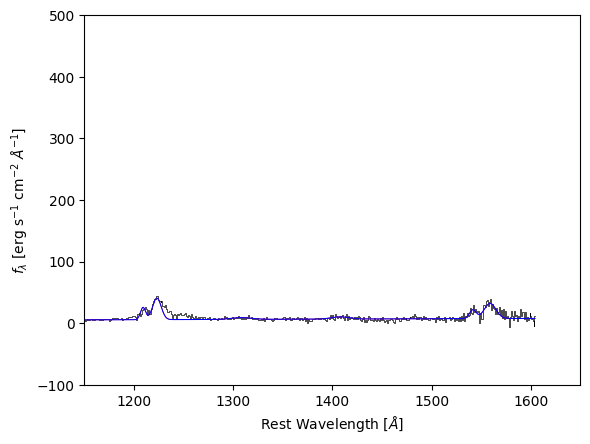

In [385]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
spec.plotter(xmin=1150,xmax=1650,ymin=-100,ymax=500,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
spec.specfit.plot_components()
plt.show()

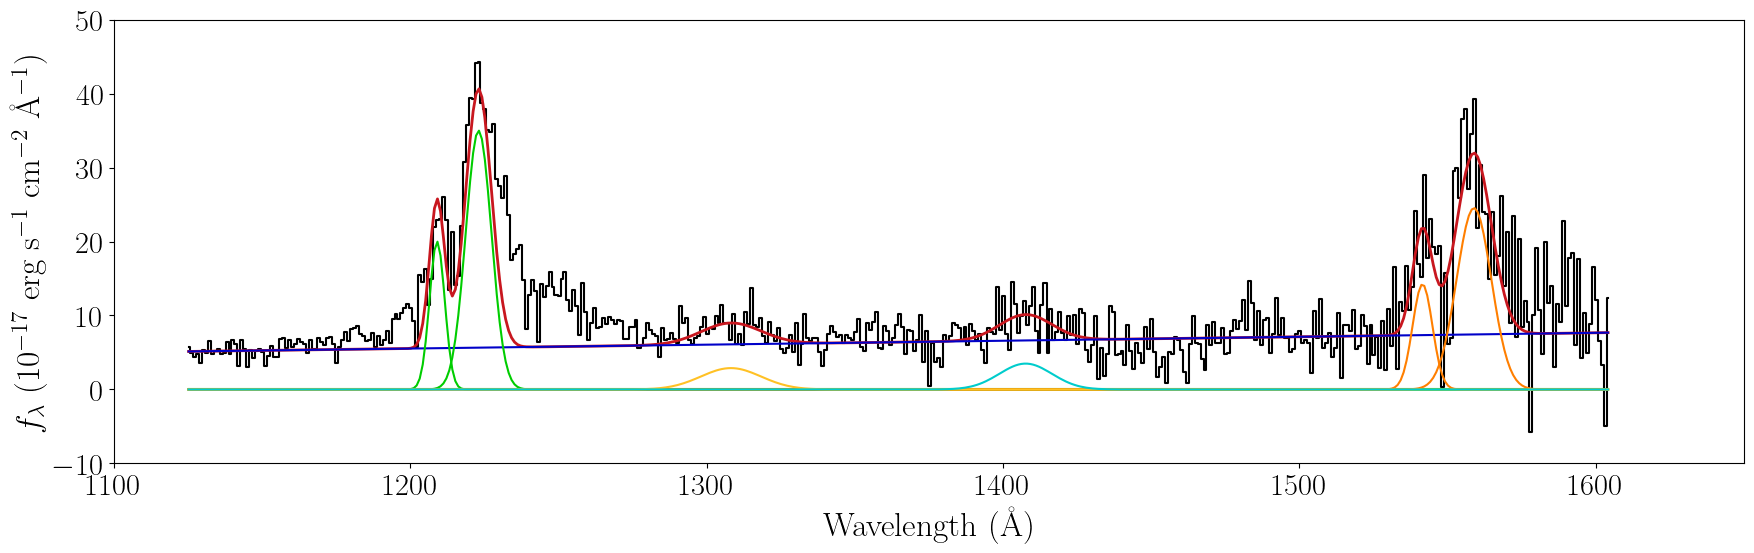

In [386]:
best_model = uv_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)
wavemin = 1000.
wavemax = 1650.
ymin = -100.
ymax = 400.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength $[\AA]$'
ylabel = '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
plotfile = 'uv1'
HARDCOPY = False
SHOW = True
plt.rc('text', usetex=True)
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 22
})

plot_uv_agn_fit(lam,flux,best_model,1100,1650,-10,50,'Wavelength (\AA)',\
                     '$f_{\lambda}$ (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)',\
                     plotfile,HARDCOPY=False,SHOW=True)

In [387]:
print(spec.specfit.parinfo.values[0: 2])

[4.496868263916702, -1.133109042001093]
